In [1]:
import lsdb
import ast
from tape import Ensemble, ColumnMapper
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
from collections.abc import Iterable

#dask.config.set({'temporary_directory': '/data/epyc/users/brantd/tmp'})
dask.config.set({'dataframe.query-planning': False})

from dask.distributed import Client, performance_report
client = Client(n_workers=4, threads_per_worker=1,
                #memory_limit="20G",
                dashboard_address=':38763')

# Dask Investigation: Understanding Partition Sizes

In [2]:
# Set the partition sizes to evaluate
partition_sizes = ("100KB", "1MB", "10MB", "100MB", "500MB", "1GB") #"200MB", "500MB")

## Generate some toy data

In [3]:
# define a generator function
def generate_data(num_points):
    num_points = num_points
    num_ids = num_points//5
    all_bands = np.array(["r", "g", "b", "i"])
    rows = {
        "id": 8000 + (np.arange(num_points) % num_ids),
        "time": np.arange(num_points),
        "flux": np.arange(num_points) % len(all_bands),
        "band": np.repeat(all_bands, num_points / len(all_bands)),
        "err": 0.1 * (np.arange(num_points) % 10),
        "count": np.arange(num_points),
        "something_else": np.full(num_points, None),
        }

    ddf = dd.from_dict(rows, npartitions=num_points//1000000).set_index("id", sort=True)

    return ddf

# Do a bunch of repartitions and write to parquet
ddf = generate_data(80*1000000).persist()
for size in partition_sizes:
    size_ddf = ddf.repartition(partition_size=size)
    size_ddf.to_parquet(f"./data/{size}")


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 3.43 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 3.43 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-14 08:50:49,155 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle af013512d7f2ad332493d66ffe6b42ea initialized by task ('shuffle-transfer-af013512d7f2ad332493d66ffe6b42ea', 9) executed on worker tcp://127.0.0.1:44783
2024-03-14 08:51:33,159 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle af013512d7f2ad332493d66ffe6b42ea deactivated due to stimulus 'task-finished-1710431493.1553478'


## Define a Rough Task Graph Memory Estimator

In [6]:
import sys
import time

def get_size(obj, seen=None):
    """Recursively finds size of objects"""

    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()

    obj_id = id(obj)
    if obj_id in seen:
        return 0

    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])

    return size

def approx_memusage(df):
    """Approximates Task Graph Memory Usage"""

    graph = df.__dask_graph__().to_dict()  # Convert to a dictionary
    size = get_size(graph)
    return size/1048576


def workflow_wrapper(dsk, size, workflow_label):
    task_graph_size = approx_memusage(dsk)
    partitions = dsk.npartitions
    with performance_report(filename=f"./data/{workflow_label}_{size}_report.html"):
        time0 = time.time()
        res = dsk.compute()
        time1 = time.time()

    return res, time1-time0, task_graph_size, partitions

def partition_string_to_float(size):
    #assume 2 spaces for byte unit, won't work for bytes
    mem_unit = size[-2:]
    if mem_unit.upper() == "KB":
        scale_factor=1024
    elif mem_unit.upper() == "MB":
        scale_factor = 1024**2
    elif mem_unit.upper() == "GB":
        scale_factor = 1024**3
    return float(size[:-2])* scale_factor

## Investigation 1: The Importance of Partition Size

In [5]:
times = []
graph_sizes = []
n_partitions = []
for size in partition_sizes:
    data_path = f"./data/{size}"
    res, compute_time, graph_size, partitions = workflow_wrapper(dd.read_parquet(data_path), size, "read")
    times.append(compute_time)
    graph_sizes.append(graph_size)
    n_partitions.append(partitions)

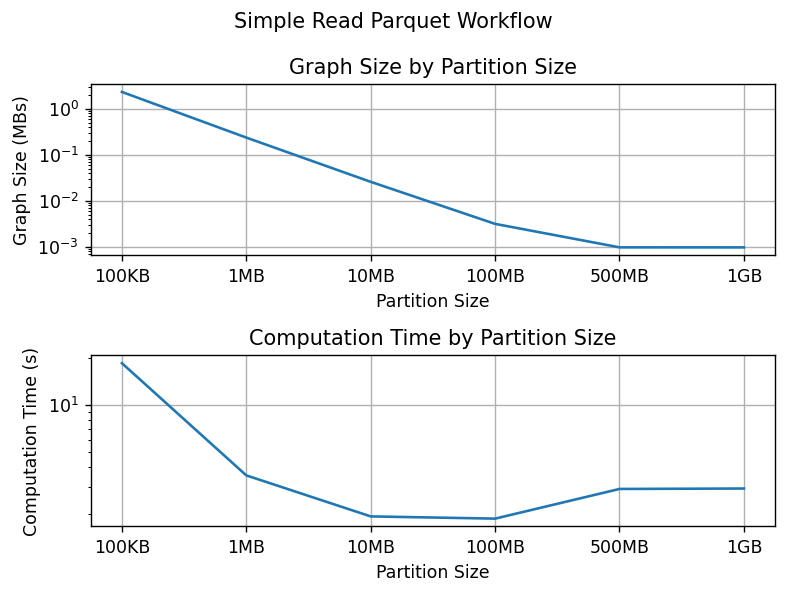

In [6]:
float_sizes = [partition_string_to_float(size) for size in partition_sizes]
fig, (ax0, ax1) = plt.subplots(2,1, dpi=125)
fig.suptitle("Simple Read Parquet Workflow")

ax0.plot(partition_sizes, graph_sizes)
ax0.set_title("Graph Size by Partition Size")
ax0.set_ylabel("Graph Size (MBs)")
ax0.set_xlabel("Partition Size")
ax0.grid()
ax0.set_yscale("log")

ax1.plot(partition_sizes, times)
ax1.set_title("Computation Time by Partition Size")
ax1.set_ylabel("Computation Time (s)")
ax1.set_xlabel("Partition Size")
ax1.set_yscale("log")
ax1.grid()

plt.tight_layout()

### The Difference is Not Just "Dask Overhead"

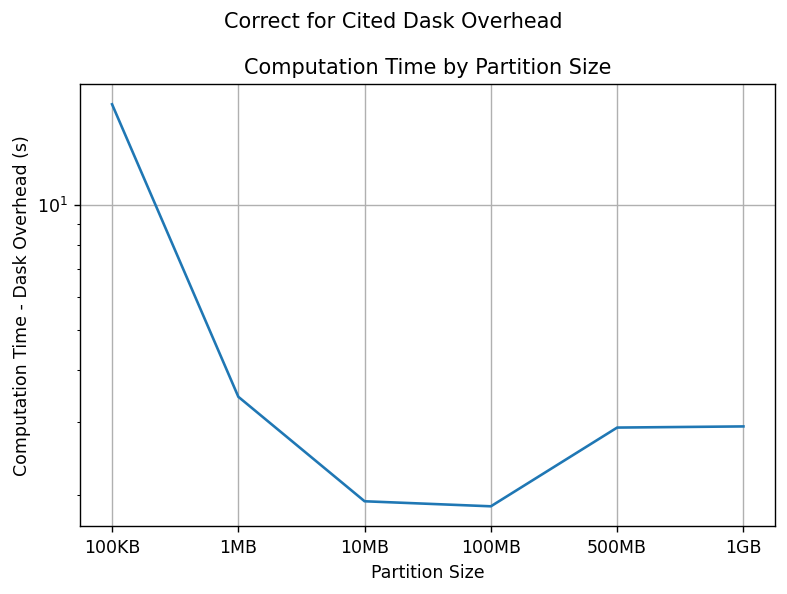

In [7]:
n_partitions # equals n_tasks for this workflow
per_task_overhead = 0.001 # 1ms worst case

times_minus_overhead = [time - (0.001*npartition)/4 for time, npartition in zip(times, n_partitions)]

fig, ax1 = plt.subplots(1,1, dpi=125)
fig.suptitle("Correct for Cited Dask Overhead")

ax1.plot(partition_sizes, times_minus_overhead)
ax1.set_title("Computation Time by Partition Size")
ax1.set_ylabel("Computation Time - Dask Overhead (s)")
ax1.set_xlabel("Partition Size")
ax1.set_yscale("log")
ax1.grid()

plt.tight_layout()

### So what is it? Pyarrow and Fsspec

In [8]:
from IPython.display import HTML

# In this report, we see from the Worker Profile (compute) tab that the _read_table_from_path and the table_to_block_manager tasks are the main bottlenecks
# Tip for reading these profile plots: Look for the largest difference between one layer and the next to see bottlenecks
HTML("./data/read_100MB_report.html")

In [9]:
# With the 100KB report, we see that the __init__ of the pyarrow parquet reader and the __init__ of fsspec file opener are much more significant fractions of the time
HTML("./data/read_100KB_report.html")

## Investigation 2: People hate Dask because Dask hates bad code
Subtitle: And unfortunately Pandas gives us many ways to write bad code


In [7]:
dask.config.set({'dataframe.query-planning': False})

# Purge client memory
client.restart()

2024-03-14 09:00:00,906 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:00:00,944 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:00:01,000 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:00:01,019 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38763/status,
Dashboard: http://127.0.0.1:38763/status,Workers: 4
Total threads: 4,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46572,Workers: 4
Dashboard: http://127.0.0.1:38763/status,Total threads: 4
Started: 11 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46236,Total threads: 1
Dashboard: http://127.0.0.1:33168/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:38301,


In [8]:
# Let's define what looks like a reasonable function
def transform_flux(df):
    df["flux"] += 1
    return df

ddf_w2 = dd.read_parquet("./data/100MB/", index="id", calculate_divisions=True)
ddf_w2 = ddf_w2.query("band == 'r'")
ddf_w2 = ddf_w2.apply(transform_flux, axis=1, meta=ddf_w2._meta)
bad_res, bad_compute_time, bad_graph_size, bad_npartitions = workflow_wrapper(ddf_w2, size="100MB", workflow_label="bad_transform")

2024-03-14 09:01:04,509 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-14 09:01:07,534 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-14 09:01:11,038 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-14 09:01:11,967 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-03-14 09:01:13,003 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-03-14 09:01:14,566 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-14 09:01:16,705 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-03-14 09:01:18,918 - distributed.utils_perf - WARNING - full garbage collections took

In [10]:
# Let's do an equivalent operation, but a different way


ddf_w2 = dd.read_parquet("./data/100MB/", index="id", calculate_divisions=True)
ddf_w2 = ddf_w2.query("band == 'r'")
ddf_w2 = ddf_w2.assign(flux= lambda x: x.flux+1)
good_res, good_compute_time, good_graph_size, good_npartitions = workflow_wrapper(ddf_w2, size="100MB", workflow_label="good_transform")

In [ ]:
from IPython.display import HTML
HTML("./data/good_transform_100MB_report.html")

In [ ]:
HTML("./data/bad_transform_100MB_report.html")

## Investigation 3: Dask Expressions?

In [11]:
# Purge client memory
client.restart()

2024-03-14 09:10:43,404 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:10:43,443 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:10:43,519 - distributed.nanny - WARNING - Restarting worker
2024-03-14 09:10:44,015 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38763/status,
Dashboard: http://127.0.0.1:38763/status,Workers: 4
Total threads: 4,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46572,Workers: 4
Dashboard: http://127.0.0.1:38763/status,Total threads: 4
Started: 22 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:41057,Total threads: 1
Dashboard: http://127.0.0.1:43796/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:38301,


In [12]:
%%time

import dask_expr as dx


# Let's define what looks like a reasonable function
def transform_flux(df):
    df["flux"] += 1
    return df

ddf_w2 = dx.read_parquet("./data/100MB/", index="id", calculate_divisions=True)
ddf_w2 = ddf_w2.query("band == 'r'")
ddf_w2 = ddf_w2.apply(transform_flux, axis=1, meta=ddf_w2._meta)
with performance_report(filename=f"./data/bad_transform_dask_expr_100MB_report.html"):
    res = ddf_w2.compute()
#bad_res, bad_compute_time, bad_graph_size, bad_npartitions = workflow_wrapper(ddf_w2, size="100MB", workflow_label="bad_transform_dask_expr")

2024-03-14 09:12:28,865 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-03-14 09:12:30,830 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-03-14 09:12:33,305 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-03-14 09:12:34,040 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-03-14 09:12:36,396 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-03-14 09:12:38,139 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-03-14 09:12:39,351 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-03-14 09:12:40,257 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1min 11s, sys: 30.5 s, total: 1min 41s
Wall time: 12min 17s


In [13]:
from IPython.display import HTML
HTML("./data/bad_transform_dask_expr_100MB_report.html")

In [14]:
import dask_expr as dx

ddf_w2 = dx.read_parquet("./data/100MB/", index="id", calculate_divisions=True)
ddf_w2 = ddf_w2.query("band == 'r'")
ddf_w2 = ddf_w2.assign(flux= lambda x: x.flux+1)
with performance_report(filename=f"./data/good_transform_dask_expr_100MB_report.html"):
    res = ddf_w2.compute()


In [15]:
HTML("./data/good_transform_dask_expr_100MB_report.html")

## Takeaways

* Partition Sizes are very important, it goes beyond just "Dask overhead".
* There are many ways to write slow and memory-intensive Pandas/Dask code, using the Dask Dashboards profiling utility is almost a neccesity for both LSDB/TAPE developers and users.
* Dask expressions seems to not have much of an effect on speed in these cases, but does impact memory-usage (up to ~2x reduction).

## Further takeaways from other testing done
* The number of columns loaded into a catalog/dataframe does have noticeable impact on memory/speed. We should encourage users to use column subsets.
* Large task graphs will rarely ever be the cause of a failed workflow, but they're probably a symptom of other inefficiency in the workflow, the ability to load in subsets to avoid large initial task graphs would be helpful.
* Small to Large Joins are horrible for task graph size/computational efficiency.